In [10]:
!pip install pyDOE

In [11]:
from google.colab import files

uploaded = files.upload()

## You have to navigate to Data and upload 'burgers_shock_mu_01_pi.mat'
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving burgers_shock_mu_01_pi.mat to burgers_shock_mu_01_pi.mat
User uploaded file "burgers_shock_mu_01_pi.mat" with length 157214 bytes


# Inspired from Raissi et al
# Link: https://maziarraissi.github.io/PINNs/

This notebook implementes a Physics Informed Neural Network to approximate a solution to burgers equation.

In [27]:
import torch
from tqdm import tqdm

class PINN(torch.nn.Module):
    
    def __init__(self, layers = [10,10], device = None):
        super(PINN, self).__init__() # inherit methods from torch
        
        # set to use GPU if available
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        # store hidden layer activation function
        self.hidden_activation = torch.nn.Tanh().to(device)
        
        # initialize nn architecture:
        self.input_layer = torch.nn.Linear(2,layers[0]).to(device)
        self.input_activation = torch.nn.Tanh().to(device)
        self.hidden = torch.nn.ModuleList([torch.nn.Linear(layers[i], layers[i+1]).to(device) for i in range(len(layers)-1)])
        self.output_layer = torch.nn.Linear(layers[-1],1).to(device)
        
        
        # init weights and biases:
        
        torch.nn.init.xavier_normal_(self.input_layer.weight.data, gain=1.0)
        torch.nn.init.zeros_(self.input_layer.bias.data)
        
        for i in range(len(layers) - 1):
            
            # set weights from normal distribution 
            torch.nn.init.xavier_normal_(self.hidden[i].weight.data, gain=1.0)
            
            # init biases as zero
            torch.nn.init.zeros_(self.hidden[i].bias.data)
            
        torch.nn.init.xavier_normal_(self.output_layer.weight.data, gain=1.0)
        torch.nn.init.zeros_(self.output_layer.bias.data)
        
        
    def forward(self, x_in): 
        
        # convert to tensor
        if torch.is_tensor(x_in) != True:         
            x_in = torch.from_numpy(x_in)
        
        # input layer
        x = self.input_layer(x_in)
        x = self.input_activation(x)
        
        # loop through hidden layers
        for i in range(len(self.hidden)):
            x = self.hidden_activation(self.hidden[i](x))
        
        x_out = self.output_layer(x)
        
        return x_out
        
    def MSE(self, y_pred, y_test):
        return torch.mean((y_pred - y_test)**2)
    
    def init_weights(self, shape):
        d_in = shape[0]
        d_out = shape[1]
        var = torch.tensor([2.0/(d_in + d_out)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)
    
    def train_step(self, closure = True):
        
        if closure:
            self.optimizer.zero_grad()
            
        # fluid dynamic viscosity
        nu = 0.01/np.pi
            
        # predict solution to boundary condition
        bc_pred = self.forward(self.x_bc) #[x,t]
        self.mse_u = self.MSE(bc_pred, self.u_bc)
        #self.loss_u.append([i, self.mse_u])
        
        # predict u w/ network
        self.x.requires_grad = True # allow grad for optimizer
        u_pred = self.forward(self.x)
        
        # differentiate using auto grad:
        
        # 1st deriv wrt X = [x,t]
        deriv1 = torch.autograd.grad(u_pred,
                                    self.x,
                                    torch.ones([self.x.shape[0], 1]).to(self.device),
                                    retain_graph = True,
                                    create_graph = True)[0]
        
        # 2nd deriv wrt X
        deriv2 = torch.autograd.grad(deriv1,
                                    self.x, 
                                    torch.ones(self.x.shape).to(self.device),
                                    create_graph = True)[0]
        
        du_dx = deriv1[:,[0]]
        du_dt = deriv1[:,[1]]
        
        d2u_dx2 = deriv2[:,[0]] #- nu *1
        d2u_dt2 = deriv2[:,[1]] #0
        
        # du/dt + u * du/dx - nu *d2u/dx2
        f = du_dt + u_pred*du_dx - nu*d2u_dx2

        self.mse_f = self.MSE(f, self.f_hat)
        self.loss = self.mse_u + self.mse_f
        
        if closure:
            self.loss.backward()
            
        return self.loss
    
    def train(self, x_bc, u_bc, x,
              learning_rate = 1e-4,
              epochs = int(1e4)):
        
        # declare variables
        self.x_bc = x_bc if torch.is_tensor(x_bc) else torch.from_numpy(x_bc).float().to(device)  
        self.u_bc = u_bc if torch.is_tensor(u_bc) else torch.from_numpy(u_bc).float().to(device)
        self.x = x if torch.is_tensor(x) else torch.from_numpy(x).float().to(device)
        self.f_hat = torch.zeros(x.shape[0],1).to(device) # PDE Loss is minimized to zero
        
        # loss history
        self.loss_u = []
        self.loss_f = []
        loss_t = []
        
        # send pinn to device
        self.to(self.device)
        
        # quasi newton method
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=0.2, 
                              max_iter = 200, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe') 
        self.optimizer.step(self.train_step)
        
        optimizer = torch.optim.Adam(self.parameters(), 
                       lr= learning_rate,
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=0, 
                       amsgrad=False)
        
        for i in tqdm(range(epochs)):
            
            loss = self.train_step(closure = False)
            loss_t.append(loss)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        return loss_t
    
    def predict(self, x_test):
        
        if torch.is_tensor(x_test) != True: 
            x_test = torch.from_numpy(x_test).float().to(device)
        
        u_pred = self.forward(x_test) 
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(256,100),order='F')
        
        return u_pred
    
    def error(self, x_test, y_true):
        u_pred = self.forward(x_test)
        return (torch.linalg.norm((y_true-u_pred),2)/torch.linalg.norm(y_true,2)).item()

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
plt.rcParams['figure.figsize'] = [15, 10]

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sample
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)


In [29]:
# Burgers matlab solution data used in Raissi et al for burgers equation
data = scipy.io.loadmat('burgers_shock_mu_01_pi.mat')  	
x = data['x']                                 
t = data['t']                                   
usol = data['usol']                            

u_true = usol.flatten('F')[:,None] 

X, T = np.meshgrid(x,t)         

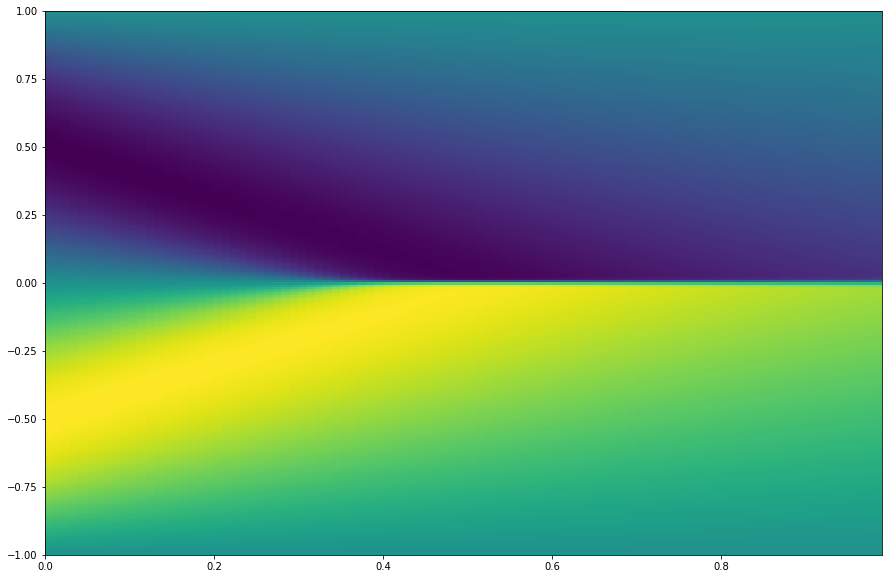

In [30]:
plt.pcolormesh(T,X, usol.T.reshape(100,256)) # solution

In [31]:
test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# bounds 
lb = test[0] 
ub = test[-1] 

In [32]:
# uses ics and bcs to sample data from for training

def gen_data(n_bc,n_coll):

    # init conditions t = 0 for all x
    initial_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) 
    initial_u = usol[:,0][:,None]

    # bottom boundary x = -1 for all t
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) 
    bottomedge_u = usol[-1,:][:,None]

    # top boundary, x = 1 for all t
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) 
    topedge_u = usol[0,:][:,None]
    
    all_bc_ic_x = np.vstack([initial_x, bottomedge_x, topedge_x]) 
    all_bc_ic_u = np.vstack([initial_u, bottomedge_u, topedge_u])   

    # samples bc 
    idx = np.random.choice(all_bc_ic_x.shape[0], n_bc, replace=False) 

    bc_ic_x = all_bc_ic_x[idx, :] # sample idx coordinates
    bc_ic_u = all_bc_ic_u[idx,:]  # corresponding solution

    # sample coll points for training in domain
    f_x = lb + (ub-lb)*lhs(2,n_coll) 
    f_x = np.vstack((f_x, bc_ic_x)) 

    return f_x, bc_ic_x, bc_ic_u 


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'Generate Training data'
n_bc = 100 
n_coll = 10000 
f_x, bc_ic_x, bc_ic_u = gen_data(n_bc,n_coll)

test_tensor = torch.from_numpy(test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)

In [34]:
l1 = [50,50,50,50,50,50,50,50,50,50]
l2 = [20,20,20,20,20,20,20,20,20]
l3 = [20,50,100,100,100,100,100,100,50,20]

pinn = PINN(layers = l2)  

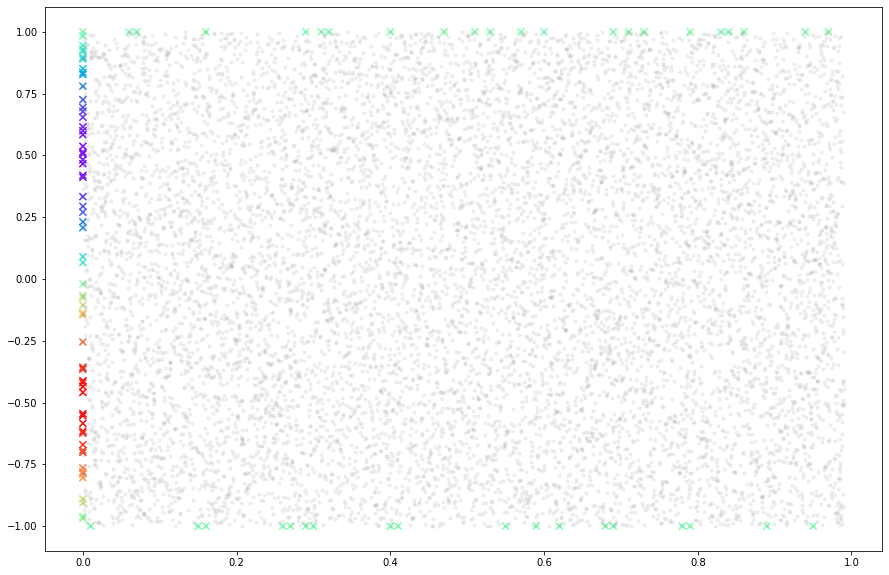

In [35]:
# this is all the information the PINN receives
plt.scatter(bc_ic_x[:,1],bc_ic_x[:,0].T, c = bc_ic_u, marker = 'x', s = 50, cmap = 'rainbow')
plt.scatter(f_x[:,1], f_x[:,0].T, alpha = 0.1, s = 10, c = 'gray')

In [36]:
import time
t1 = time.time()
loss = pinn.train(bc_ic_x, bc_ic_u, f_x,
                  epochs = 2000)
print(time.time() - t1)

100%|██████████| 2000/2000 [03:40<00:00,  9.06it/s]


243.06607174873352


In [37]:
u_pred = pinn.predict(test)

In [38]:
# calc error
error = pinn.error(test_tensor, u)
error

0.18140415847301483

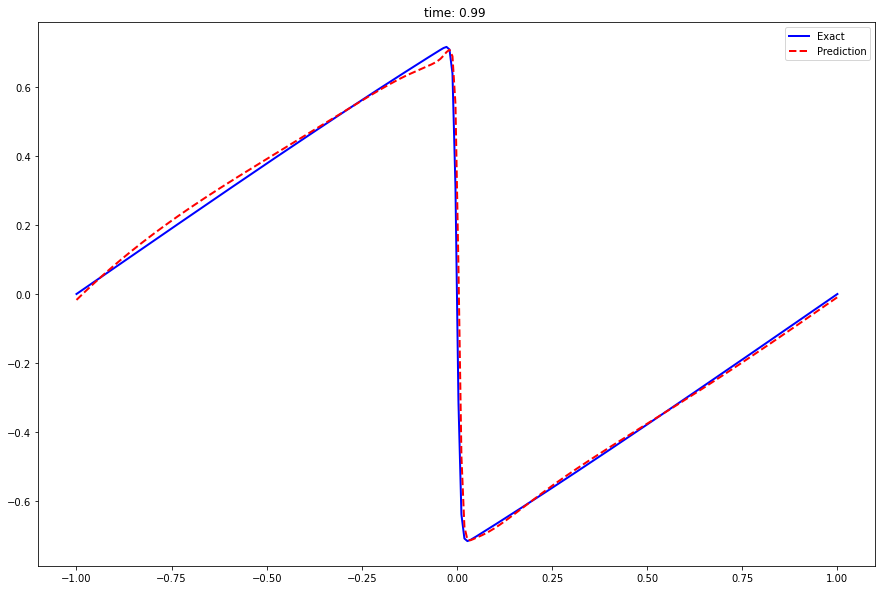

In [39]:
from IPython.display import clear_output

time_space = np.arange(100)
for time_t in time_space:
    
    plt.plot(x,usol.T[time_t,:], 'b-', linewidth = 2, label = 'Exact')
    plt.plot(x,u_pred.T[time_t,:], 'r--', linewidth = 2, label = 'Prediction')
    plt.title('time: {} '.format(time_t/100))
    plt.legend()
    plt.show()
    clear_output(wait=True)

# Re-sample ic and bc during training

In [40]:
l1 = [50,50,50,50,50,50,50,50,50,50]
l2 = [20,20,20,20,20,20,20,20,20]
l3 = [20,50,100,100,100,100,100,100,50,20]

pinn = PINN(layers = l2)  
test_tensor = torch.from_numpy(test).float().to(device)

t1 = time.time()
for i in range(5):
    
    'Generate Training data'
    n_bc = 100 
    n_coll = 10000 
    f_x, bc_ic_x, bc_ic_u = gen_data(n_bc,n_coll)

    
    
    loss = pinn.train(bc_ic_x, bc_ic_u, f_x,
                  epochs = 250)
    
print(time.time() - t1)

100%|██████████| 250/250 [00:27<00:00,  9.02it/s]

248.62458896636963


In [41]:
bc_ic_x = torch.from_numpy(bc_ic_x).float().to(device)
bc_ic_u = torch.from_numpy(bc_ic_u).float().to(device)

u_pred1 = pinn.predict(test)

In [42]:
error = pinn.error(test_tensor, u)
error

0.026665864512324333

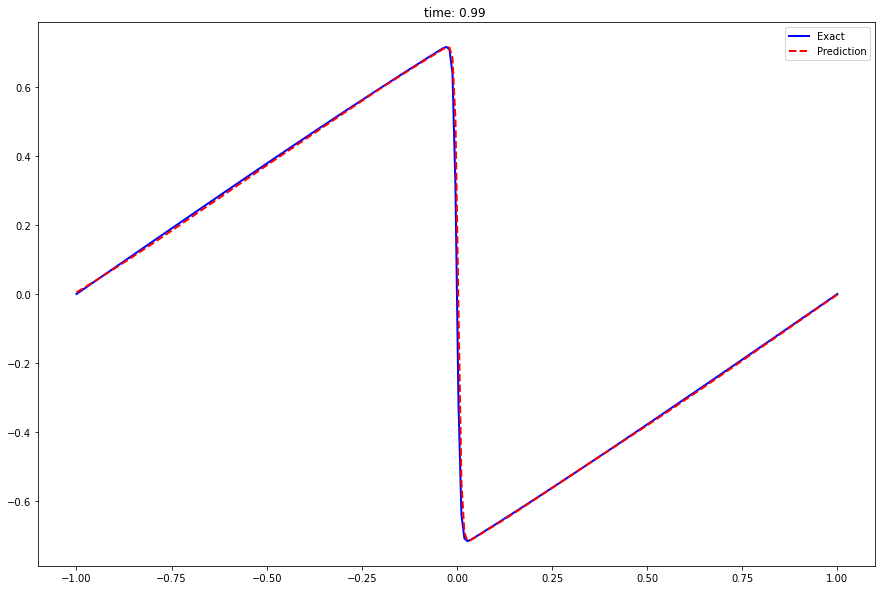

In [45]:
from IPython.display import clear_output

time_space = np.arange(100)
for time_t in time_space:
    
    plt.plot(x,usol.T[time_t,:], 'b-', linewidth = 2, label = 'Exact')
    plt.plot(x,u_pred1.T[time_t,:], 'r--', linewidth = 2, label = 'Prediction')
    plt.title('time: {} '.format(time_t/100))
    plt.legend()
    plt.show()
    clear_output(wait=True)

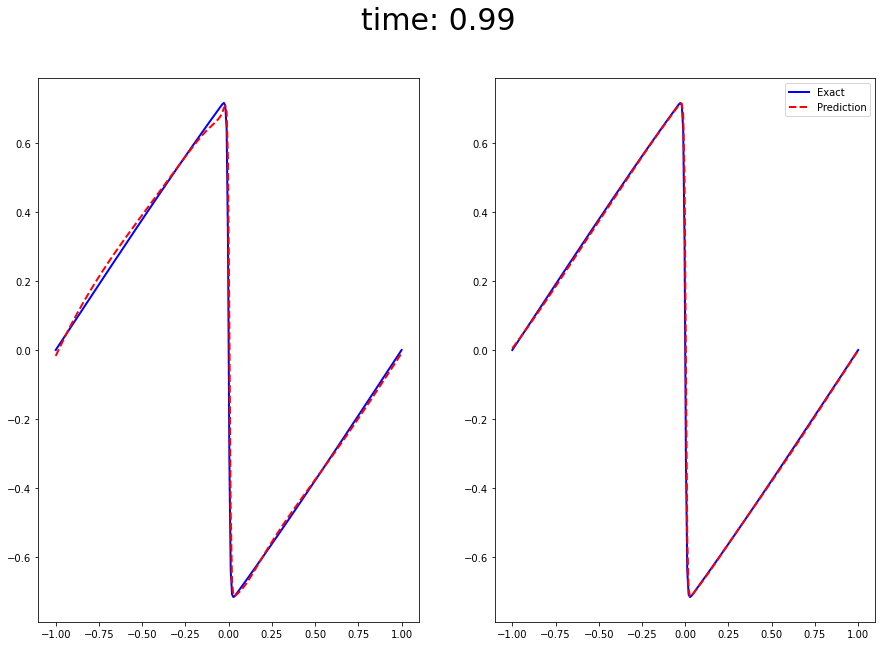

In [44]:
from IPython.display import clear_output

#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Horizontally stacked subplots')
#plt.title('hi')
time_space = np.arange(100)
for time_t in time_space:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('time: {} '.format(time_t/100), size = 30)
    
    ax1.plot(x,usol.T[time_t,:], 'b-', linewidth = 2, label = 'Exact')
    ax1.plot(x,u_pred.T[time_t,:], 'r--', linewidth = 2, label = 'Prediction')
    
    ax2.plot(x,usol.T[time_t,:], 'b-', linewidth = 2, label = 'Exact')
    ax2.plot(x,u_pred1.T[time_t,:], 'r--', linewidth = 2, label = 'Prediction')
    ax2.legend()
    plt.show()
    clear_output(wait=True)

# Results Evaluation

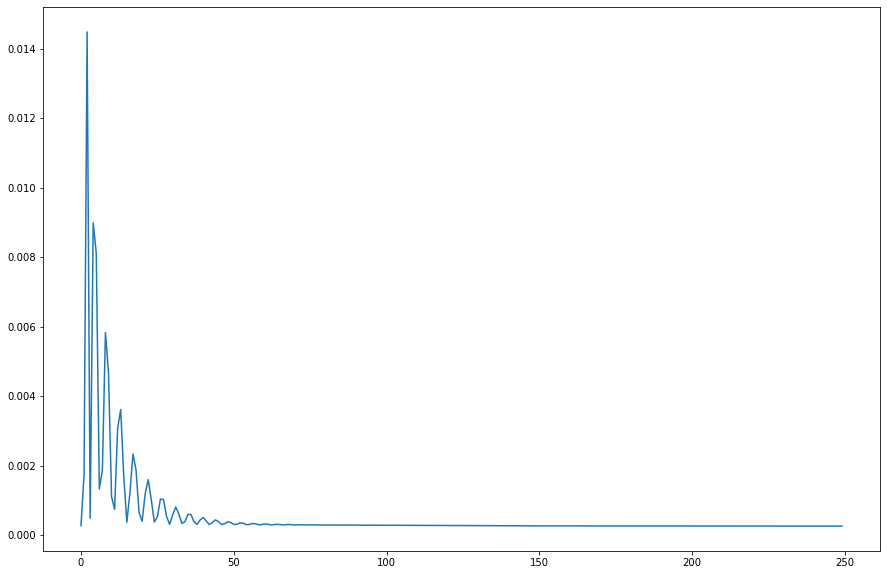

In [ ]:
plt.plot(np.arange(len(loss)), loss)

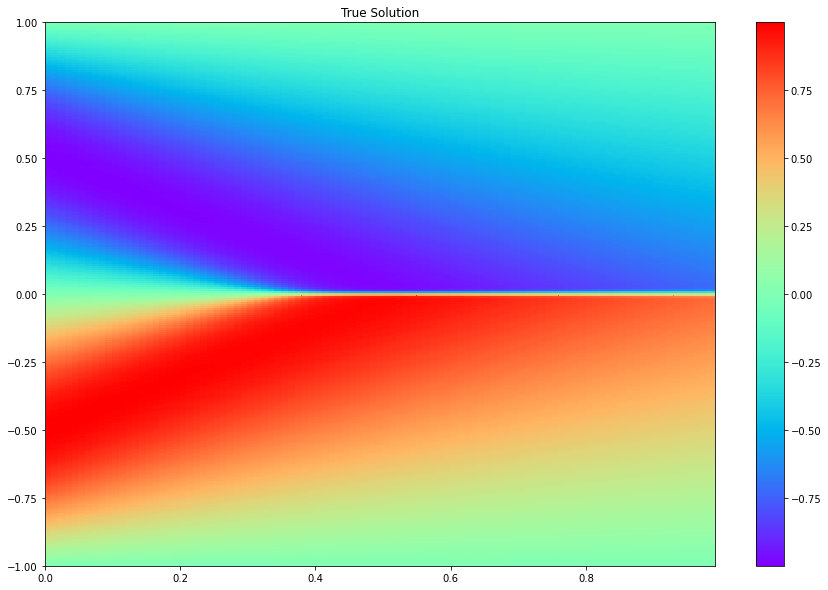

In [ ]:
time_t = 0.0
plt.pcolormesh(T,X,usol.T, cmap = 'rainbow')
plt.colorbar()
plt.axvline(time_t, color = 'white', linestyle = '-', linewidth = 1)
plt.title('True Solution')
plt.show()

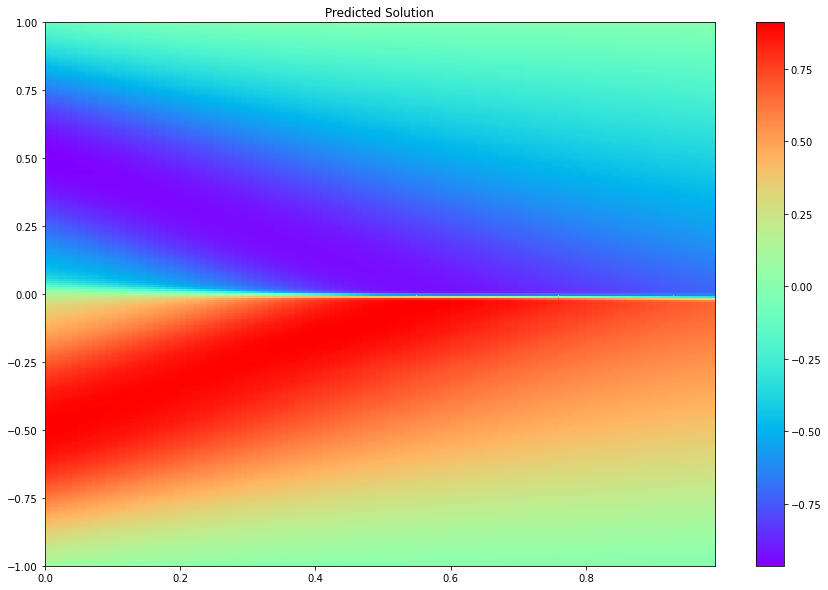

In [ ]:
plt.pcolormesh(T,X,u_pred.T, cmap = 'rainbow')
plt.colorbar()
plt.axvline(time_t, color = 'white', linestyle = '-', linewidth = 1)
plt.title('Predicted Solution')
plt.show()

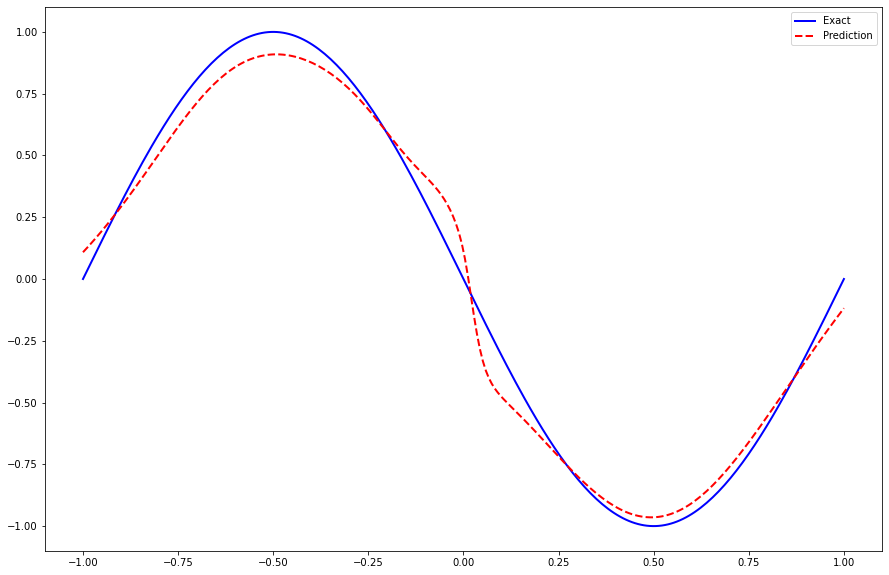

In [ ]:
plt.plot(x,usol.T[int(time_t*100),:], 'b-', linewidth = 2, label = 'Exact')       
plt.plot(x,u_pred.T[int(time_t*100),:], 'r--', linewidth = 2, label = 'Prediction')
plt.legend()

In [ ]:
error = usol.T - u_pred.T

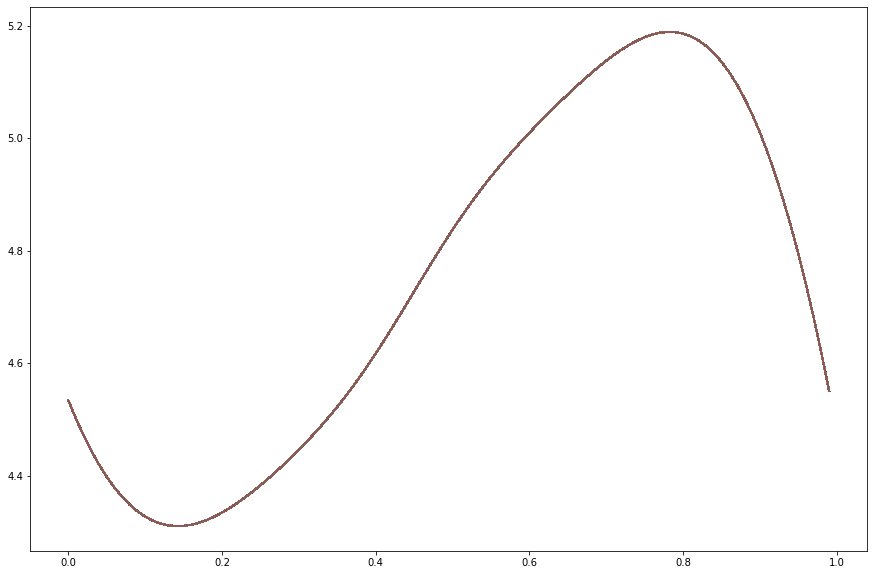

In [ ]:
e = np.sum(error, axis = 1)
plt.plot(T,e)
plt.show()

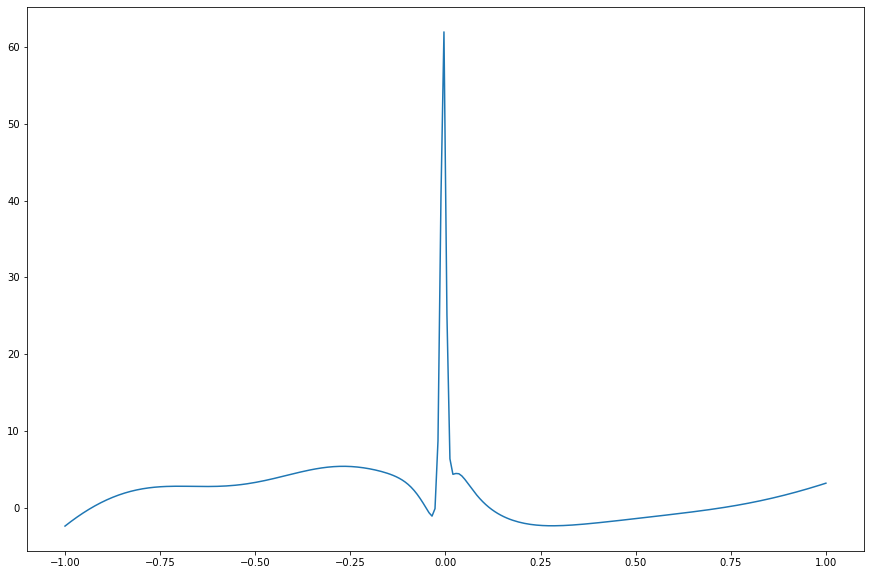

In [ ]:
e = np.sum(error, axis = 0)

plt.plot(x,e)
plt.show()

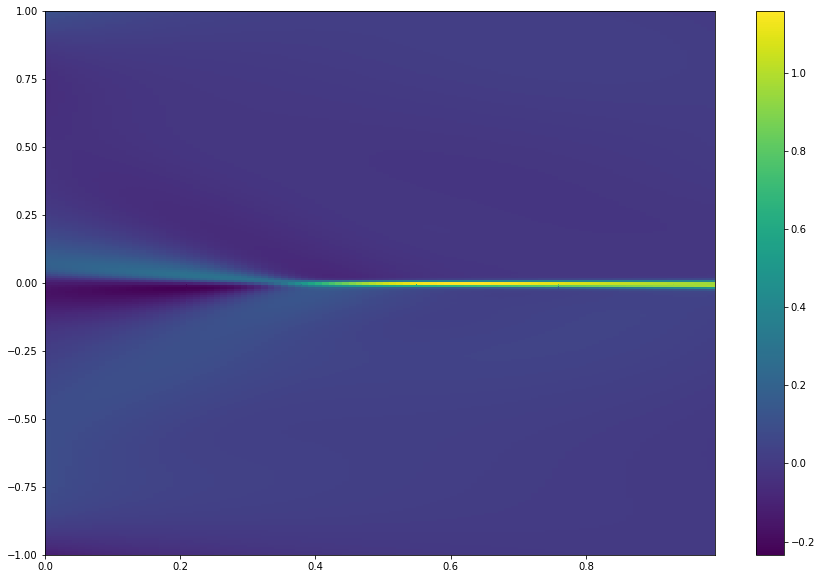

In [ ]:
plt.pcolormesh(T,X,error)
plt.colorbar()